This notebook explores the SDSS-MGS observational sample.

* Target selection: https://www.sdss3.org/dr8/algorithms/target_selection.php
* Data Release: https://arxiv.org/abs/0812.0649
* NYU Value-Added Catalog: http://sdss.physics.nyu.edu/vagc/
* Power spectrum analysis: https://arxiv.org/abs/astro-ph/0608636

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
from os.path import join as pjoin

import astropy
from astropy.io import fits
import h5py
import pandas as pd

from scipy.spatial import ConvexHull

## Load data

In [194]:
wdir = '../MGS'
# os.listdir(wdir)

In [195]:
# Load VAGC
with fits.open(pjoin(wdir, 'lss_index.dr72.fits')) as f:
    print(f.info())
    data = f[1].data

print(data.dtype.names)

# Load Tjitske's data

cols = ['RA', 'DEC', 'Z', 'MAG', 'SURVEY', 'ZSRC']
with h5py.File(pjoin(wdir, 'tinker_SDSS_centrals_M9.7.valueadd.hdf5'), 'r') as f:
    datatj = pd.DataFrame([f[col] for col in cols], index=cols).T

Filename: ../MGS/lss_index.dr72.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1                1 BinTableHDU     43   2506754R x 13C   [D, D, E, J, J, E, J, J, E, E, J, J, J]   
None
('RA', 'DEC', 'Z', 'ZTYPE', 'SECTOR', 'FGOTMAIN', 'QUALITY', 'ISBAD', 'M', 'MMAX', 'ILSS', 'ICOMB', 'VAGC_SELECT')


## Calculate other fields

In [196]:
rae = 100, 270
dece = 0, 70
ze = 0.01, 0.4
def in_range(data):
    mask = (rae[0] < data['RA']) & (data['RA'] < rae[1]) & (dece[0] < data['DEC']) & (data['DEC'] < dece[1])
    mask &= (ze[0] <= data['Z']) & (data['Z'] < ze[1])
    return mask


# mask vagc
print(len(data))
mask = (data['ILSS'] != -1) & (data['VAGC_SELECT'] == 7)
data = data[mask]

mask = in_range(data)
data = data[mask]

data = pd.DataFrame(np.array([data[col] for col in data.dtype.names]).T, columns=data.dtype.names)
print(len(data))

# mask tjitske
print(len(datatj))
mask = in_range(datatj)
datatj = datatj[mask]

for col in ['RA' ,'DEC', 'Z', 'MAG']:
    datatj[col] = datatj[col].values.astype(float)
print(len(datatj))


2506754
602356
12344
10686


In [197]:
# calculate comoving
from astropy.cosmology import Planck15 as cosmo
from astropy import units as u

def rdz_to_xyz(ra, dec, z):
    R = cosmo.comoving_distance(z)
    ra = np.radians(ra)
    dec = np.radians(dec)
    x = R * np.cos(ra) * np.cos(dec)
    y = R * np.sin(ra) * np.cos(dec)
    z = R * np.sin(dec)
    return x, y, z

data['cX'], data['cY'], data['cZ'] = rdz_to_xyz(data['RA'], data['DEC'], data['Z'])
datatj['cX'], datatj['cY'], datatj['cZ'] = rdz_to_xyz(datatj['RA'], datatj['DEC'], datatj['Z'])

tjmask = (data['Z']<0.035) & (data['Z']>0.01)

In [198]:
# measure volume of convex hull
from scipy.spatial import ConvexHull

def measure_volume(x, y, z):
    hull = ConvexHull(np.array([x, y, z]).T)
    return hull.volume  # in (Mpc/h)^3

dvol = measure_volume(data['cX'], data['cY'], data['cZ'])
dtjvol = measure_volume(datatj['cX'], datatj['cY'], datatj['cZ'])
dmvol = measure_volume(data['cX'][tjmask], data['cY'][tjmask], data['cZ'][tjmask])

## Plot comparison

[]

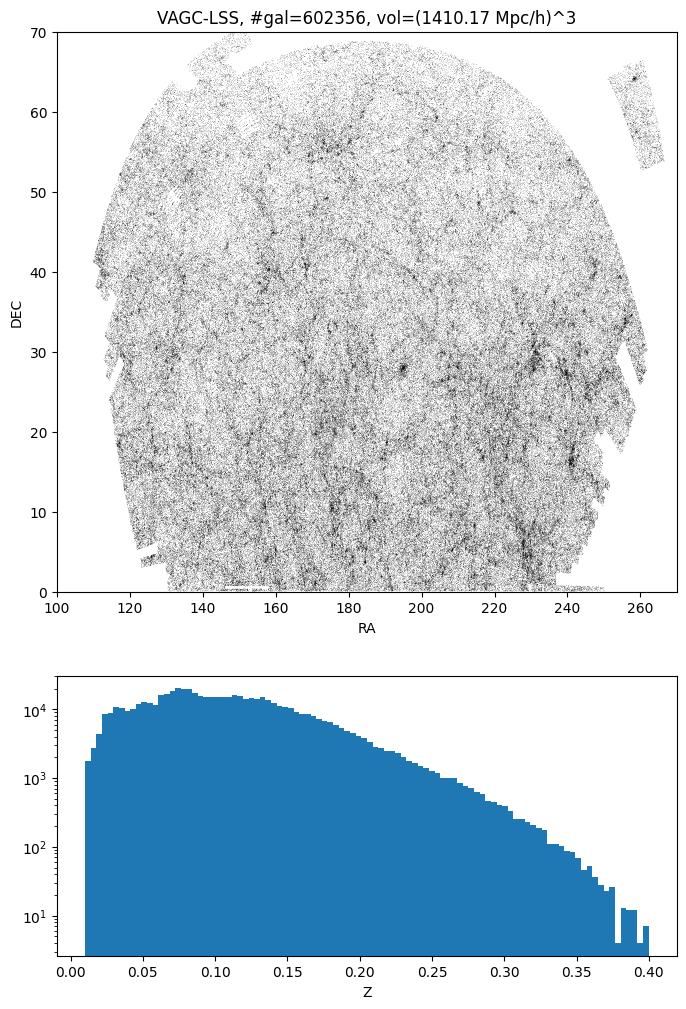

In [199]:
f = plt.figure(figsize=(8,12))
gs = f.add_gridspec(2,1, height_ratios=[1,0.5])

# vagc-lss
ax = f.add_subplot(gs[0])
ax.plot(data['RA'], data['DEC'], 'k,', alpha=0.1)
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'VAGC-LSS, #gal={len(data)}, vol=({dvol**(1/3):.2f} Mpc/h)^3')

ax = f.add_subplot(gs[1])
ax.hist(data['Z'], bins=100)
ax.set_xlabel('Z')
ax.semilogy()


Text(0.5, 0, 'Z')

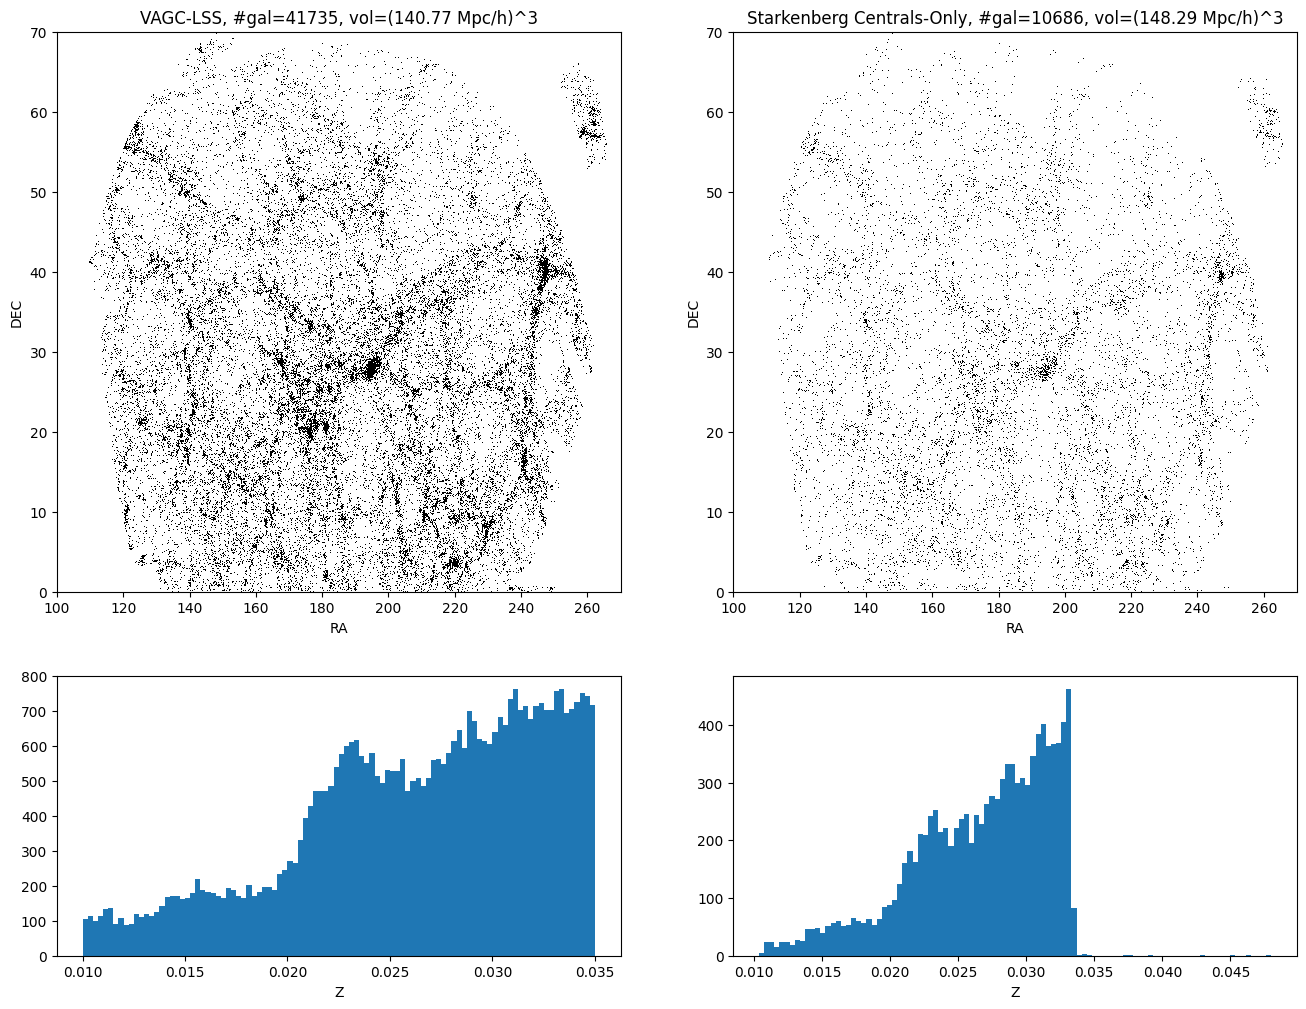

In [200]:
f = plt.figure(figsize=(16,12))
gs = f.add_gridspec(2,2, height_ratios=[1,0.5])

# vagc-lss
ax = f.add_subplot(gs[0,0])
ax.plot(data[tjmask]['RA'], data[tjmask]['DEC'], 'k,', alpha=1)
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'VAGC-LSS, #gal={len(data[tjmask])}, vol=({dmvol**(1/3):.2f} Mpc/h)^3')

ax = f.add_subplot(gs[1,0])
ax.hist(data[tjmask]['Z'], bins=100)
ax.set_xlabel('Z')
# ax.semilogy()

# tjitske
ax = f.add_subplot(gs[0,1])
ax.plot(datatj['RA'], datatj['DEC'], 'k,', alpha=1)
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'Starkenberg Centrals-Only, #gal={len(datatj)}, vol=({dtjvol**(1/3):.2f} Mpc/h)^3')

ax = f.add_subplot(gs[1,1])
ax.hist(datatj['Z'], bins=100)
ax.set_xlabel('Z')

Text(0, 0.5, 'M')

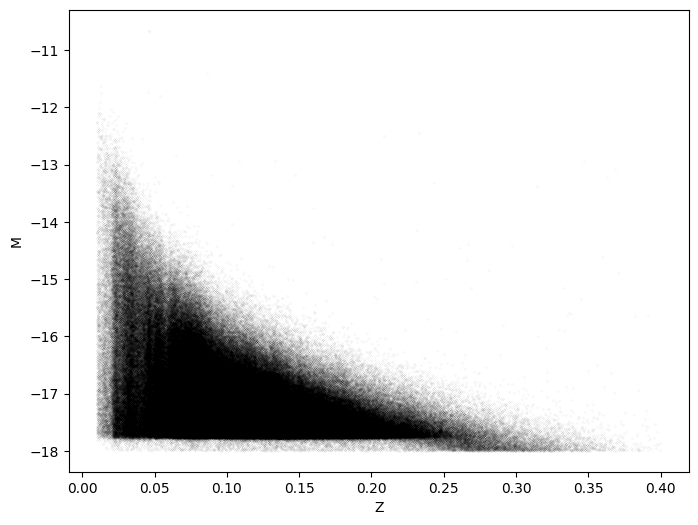

In [9]:
# plot magnitude-redshift distribution
f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(data['Z'], -data['M'], 'k.', markersize=0.1, alpha=0.5)
ax.set_xlabel('Z')
ax.set_ylabel('M')

(-20.0, 150.0)

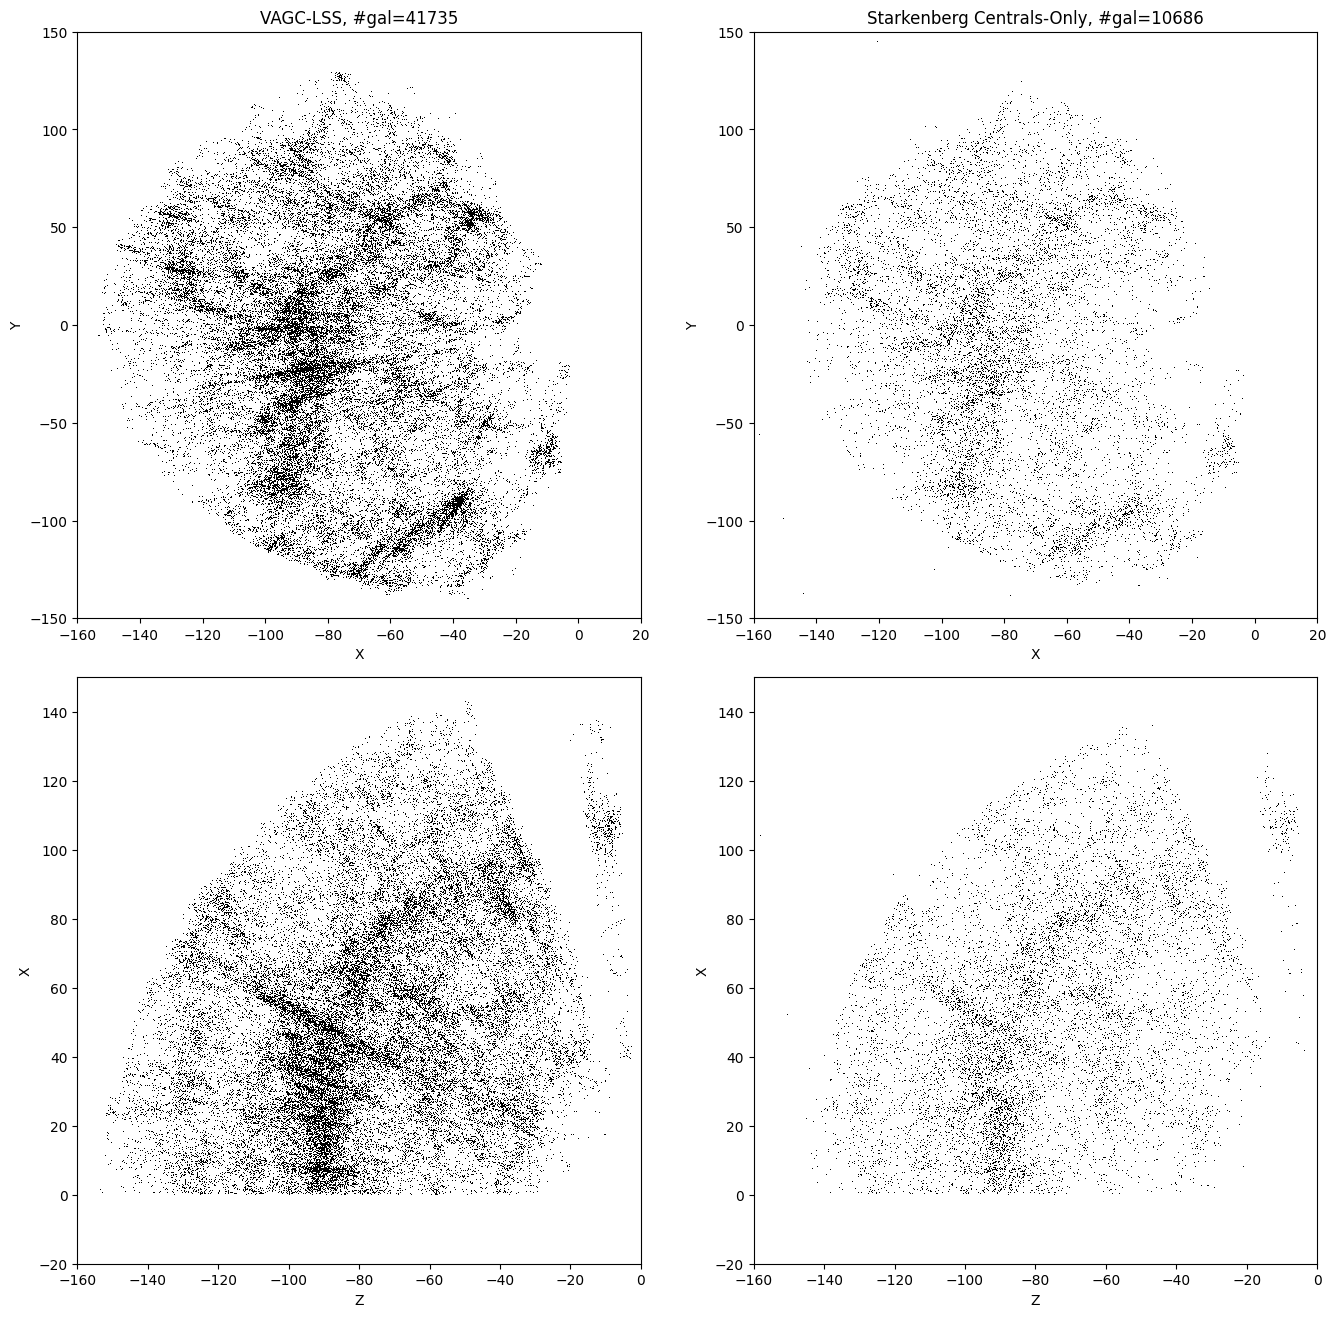

In [10]:
# plot comoving coordinates
f = plt.figure(figsize=(16,16))
gs = f.add_gridspec(2,2, height_ratios=[1,1], hspace=0.1)

# vagc-lss
ax = f.add_subplot(gs[0,0])
ax.plot(data[tjmask]['cX'], data[tjmask]['cY'], 'k,', alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'VAGC-LSS, #gal={len(data[tjmask])}')
ax.set_xlim(-160, 20)
ax.set_ylim(-150, 150)

ax = f.add_subplot(gs[1,0])
ax.plot(data[tjmask]['cX'], data[tjmask]['cZ'], 'k,', alpha=1)
ax.set_xlabel('Z')
ax.set_ylabel('X')
ax.set_xlim(-160, 0)
ax.set_ylim(-20, 150)


# tjitske
ax = f.add_subplot(gs[0,1])
ax.plot(datatj['cX'], datatj['cY'], 'k,', alpha=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Starkenberg Centrals-Only, #gal={len(datatj)}')
ax.set_xlim(-160, 20)
ax.set_ylim(-150, 150)

ax = f.add_subplot(gs[1,1])
ax.plot(datatj['cX'], datatj['cZ'], 'k,', alpha=1)
ax.set_ylabel('X')
ax.set_xlabel('Z')
ax.set_xlim(-160, 0)
ax.set_ylim(-20, 150)



## divisez en quatre

In [11]:
ramid = 187
decmid = 30

def label_quadrants(dat):
    bins = np.zeros(len(dat))
    mask = (dat['RA']<ramid) & (dat['DEC']<decmid)
    bins[mask] = 0
    mask = (dat['RA']<ramid) & (dat['DEC']>decmid)
    bins[mask] = 1
    mask = (dat['RA']>ramid) & (dat['DEC']<decmid)
    bins[mask] = 2
    mask = (dat['RA']>ramid) & (dat['DEC']>decmid)
    bins[mask] = 3
    return bins

data['bin'] = label_quadrants(data)
datatj['bin'] = label_quadrants(datatj)

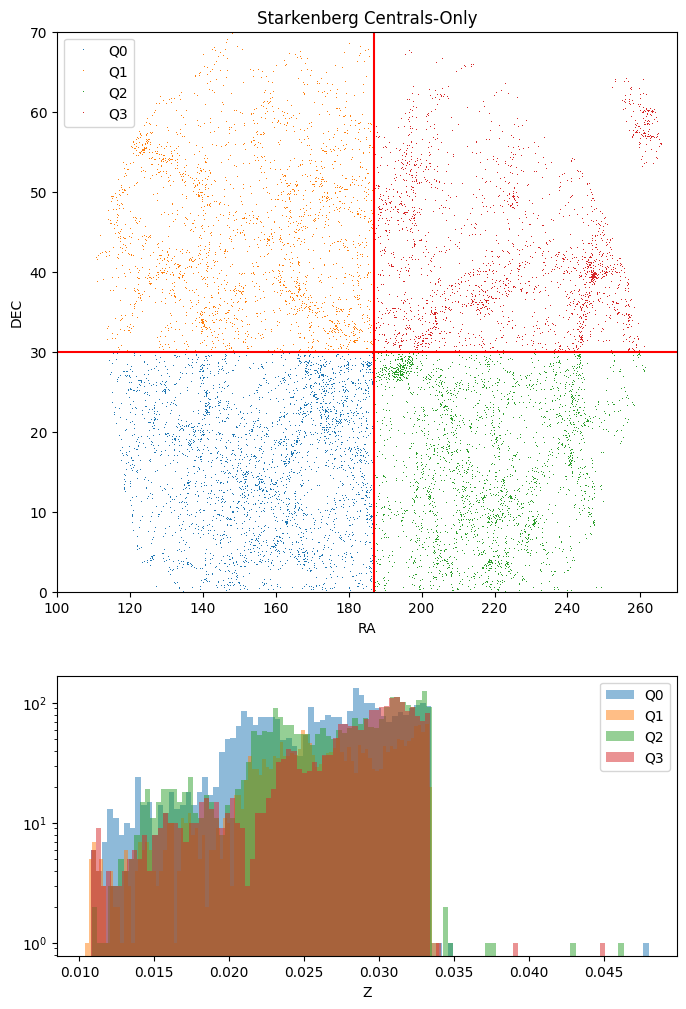

In [130]:
f = plt.figure(figsize=(8,12))
gs = f.add_gridspec(2,1, height_ratios=[1,0.5])

# tjitske
ax = f.add_subplot(gs[0])
for i in range(4):
    mask = datatj['bin'] == i
    ax.plot(datatj[mask]['RA'], datatj[mask]['DEC'], ',', alpha=1, label=f'Q{i}')
ax.legend()
ax.set_xlim(rae)
ax.set_ylim(dece)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'Starkenberg Centrals-Only')
ax.axvline(ramid, color='r')
ax.axhline(decmid, color='r')

ax = f.add_subplot(gs[1])
for i in range(4):
    mask = datatj['bin'] == i
    ax.hist(datatj[mask]['Z'], bins=100, alpha=0.5, label=f'Q{i}')
ax.set_xlabel('Z')
ax.semilogy()
ax.legend()


In [13]:
# measure volume of each bin
for i in range(4):
    mask = datatj['bin'] == i
    vol = measure_volume(datatj['cX'][mask], datatj['cY'][mask], datatj['cZ'][mask])
    print(f'Q{i}: {np.sum(mask)} gals in ({vol**(1/3):.2f} Mpc/h)^3 = {np.sum(mask)/vol:.2e} gals/(Mpc/h)^3')

Q0: 3211 gals in (90.18 Mpc/h)^3 = 4.38e-03 gals/(Mpc/h)^3
Q1: 2381 gals in (79.31 Mpc/h)^3 = 4.77e-03 gals/(Mpc/h)^3
Q2: 2863 gals in (92.00 Mpc/h)^3 = 3.68e-03 gals/(Mpc/h)^3
Q3: 2231 gals in (86.07 Mpc/h)^3 = 3.50e-03 gals/(Mpc/h)^3


## Calculate and compare P(k)

In [14]:
# Calc P(k)
from summarizer.data import SurveyCatalogue

/data80/mattho/anaconda3/envs/cmass/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# import randoms

filename = pjoin(wdir, 'random', 'lss_random-0.dr72.fits')
with fits.open(filename) as f:
    print(f.info())
    random = f[1].data

random = pd.DataFrame(np.array([random[col] for col in random.dtype.names]).T, 
                      columns=random.dtype.names)

Filename: ../MGS/random/lss_random-0.dr72.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     25   1962944R x 4C   [D, D, J, E]   
None


In [16]:
# cut randoms
mask = (rae[0] < random['RA']) & (random['RA'] < rae[1]) 
mask &= (dece[0] < random['DEC']) & (random['DEC'] < dece[1])
random = random[mask]

mask = np.random.choice(len(random), 10*len(datatj), replace=False)
random = random.iloc[mask]

In [17]:
h, be = np.histogram(datatj['Z'], bins=100)
random['ZBIN'] = np.random.choice(np.arange(len(h)), size=len(random), p=h/h.sum())
random['Z'] = np.random.uniform(be[random['ZBIN']], be[random['ZBIN']+1], size=len(random))

106860

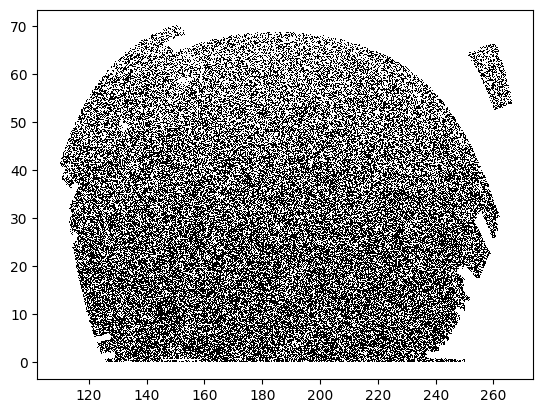

In [18]:
plt.plot(random['RA'], random['DEC'], 'k,', alpha=1)
len(random)

In [19]:
import numpy as np
from astropy.stats import scott_bin_width
from scipy.interpolate import InterpolatedUnivariateSpline
import nbodykit.lab as nblab

def get_nofz(z, fsky, cosmo=None):
    ''' calculate nbar(z) given redshift values and f_sky (sky coverage
    fraction)
    Parameters
    ----------
    z : array like
        array of redshift values 
    fsky : float 
        sky coverage fraction  
    cosmo : cosmology object 
        cosmology to calculate comoving volume of redshift bins 
    Returns
    -------
    number density at input redshifts: nbar(z) 
    Notes
    -----
    * based on nbdoykit implementation 
    '''
    # calculate nbar(z) for each galaxy
    _, edges = scott_bin_width(z, return_bins=True)

    dig = np.searchsorted(edges, z, "right")
    N = np.bincount(dig, minlength=len(edges)+1)[1:-1]

    R_hi = cosmo.comoving_distance(edges[1:])  # Mpc/h
    R_lo = cosmo.comoving_distance(edges[:-1])  # Mpc/h

    dV = (4./3.) * np.pi * (R_hi**3 - R_lo**3) * fsky

    nofz = InterpolatedUnivariateSpline(
        0.5*(edges[1:] + edges[:-1]), N/dV, ext='const')

    return nofz

In [185]:
grdz = np.array([datatj['RA'], datatj['DEC'], datatj['Z']]).T
rrdz = np.array([random['RA'], random['DEC'], random['Z']]).T

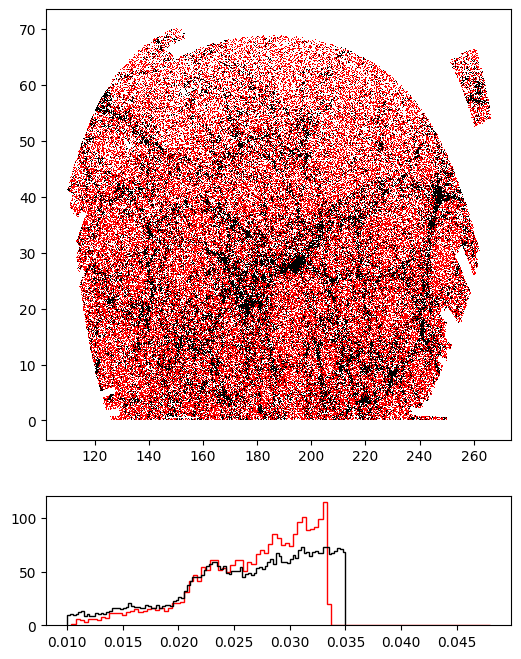

In [208]:
f, axs = plt.subplots(2, 1, figsize=(6,8), gridspec_kw={'height_ratios': [1, 0.3]})
axs[0].plot(rrdz[:,0], rrdz[:,1], 'r,', alpha=1)
axs[0].plot(grdz[:,0], grdz[:,1], 'k,', alpha=1)

axs[1].hist(rrdz[:,2], bins=100, histtype='step', color='r', density=True)
axs[1].hist(grdz[:,2], bins=100, histtype='step', color='k', density=True);

In [187]:
from cmass.summaries.tools import sky_to_xyz
from nbodykit import cosmology

fsky = 6347 / (360.0**2 / np.pi)  # where did this come from?

def calc_Pk(grdz, rrdz, fsky=fsky):
    cosmo = cosmology.Planck15  # fixed because we don't know true cosmology
    ng_of_z = get_nofz(grdz[:, -1], fsky, cosmo=cosmo)
    nbar_g = ng_of_z(grdz[:, -1])
    nbar_r = ng_of_z(rrdz[:, -1])
    weights = np.ones_like(nbar_g)

    gpos = sky_to_xyz(grdz, cosmo)
    rpos = sky_to_xyz(rrdz, cosmo)

    P0=1e1
    _gals = nblab.ArrayCatalog({
        'Position': gpos,
        'NZ': nbar_g,
        'WEIGHT': weights,
        'WEIGHT_FKP': 1./(1. + nbar_g * P0)
    })

    _rands = nblab.ArrayCatalog({
        'Position': rpos,
        'NZ': nbar_r,
        'WEIGHT': np.ones(len(rrdz)),
        'WEIGHT_FKP': 1./(1. + nbar_r * P0)
    })

    fkp = nblab.FKPCatalog(_gals, _rands)

    mesh = fkp.to_mesh(Nmesh=256, nbar='NZ', fkp_weight='WEIGHT_FKP',
                    comp_weight='WEIGHT', window='tsc')

    r = nblab.ConvolvedFFTPower(mesh, poles=[0, 2], dk=0.05, kmin=0.04)

    k_gal = r.poles['k']
    p0k_gal = r.poles['power_0'].real - r.attrs['shotnoise']
    p2k_gal = r.poles['power_2'].real
    p4k_gal = None # r.poles['power_4'].real

    return k_gal, p0k_gal, p2k_gal, p4k_gal

In [188]:
Pk0 = calc_Pk(grdz, rrdz, fsky=fsky)

INFO:FKPCatalog:cartesian coordinate range: [-1.37928059e+02 -1.23503794e+02  7.60220476e-04] : [ -1.98813032 113.92397782 122.30914609]
INFO:FKPCatalog:BoxSize = [139. 243. 125.]
INFO:FKPCatalog:BoxCenter = [-69.95809483  -4.78990819  61.15495316]
INFO:ConvolvedFFTPower:using compensation function CompensateTSCShotnoise for source 'first'
INFO:ConvolvedFFTPower:using compensation function CompensateTSCShotnoise for source 'second'
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 10686 
INFO:CatalogMesh:painted 10686 out of 10686 objects to mesh
INFO:CatalogMesh:painted 10686 out of 10686 objects to mesh
INFO:CatalogMesh:mean particles per cell is 0.000540357
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 9065.69 
INFO:FKPCatalogMesh:data painted.
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 106860 
INFO:CatalogMesh:painted 106860 out of 106860 objects to 

[Text(0.5, 0, 'k'), Text(0, 0.5, 'P2(k)')]

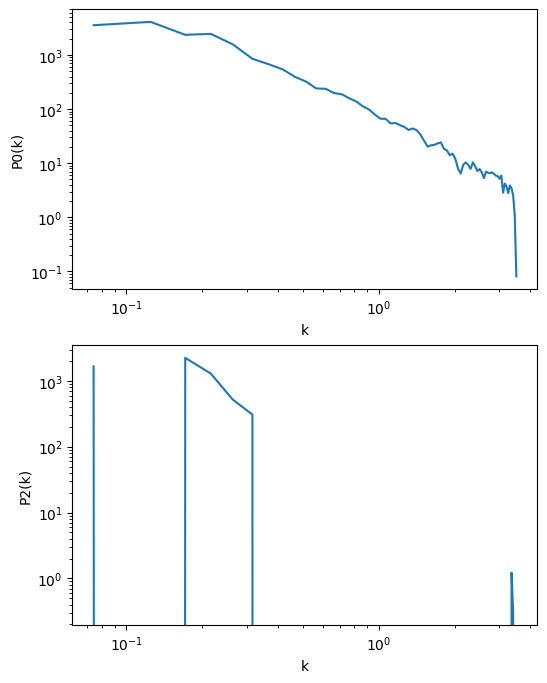

In [189]:
f, axs = plt.subplots(2, 1, figsize=(6, 8))
axs[0].loglog()
axs[0].plot(k, p0k)
axs[0].set(xlabel='k', ylabel='P0(k)')

axs[1].loglog()
axs[1].plot(k, p2k)
axs[1].set(xlabel='k', ylabel='P2(k)')

In [161]:
# ili-summarizer

# cat = SurveyCatalogue(grdz, rrdz, np.mean(grdz[:,-1]), nbar_g, nbar_r, cosmo, weights=weights)
# fkp = cat.to_nbodykit_catalogue()
# # from summarizer.two_point import Pk
# mesh = cat.to_mesh(128, weights=weights)
# runner = Pk()
# Pk = runner(cat)

## Calculate P(k) for quadrants

In [203]:
len(data), len(datatj), len(random)

(602356, 10686, 106860)

In [205]:
# data = datatj
data = data[tjmask]
data['bin'] = label_quadrants(data)
random['bin'] = label_quadrants(random)

In [209]:
# all
grdz = np.array([data['RA'], data['DEC'], data['Z']]).T
rrdz = np.array([random['RA'], random['DEC'], random['Z']]).T
Pk0 = calc_Pk(grdz, rrdz, fsky=fsky)

INFO:FKPCatalog:cartesian coordinate range: [-1.37928059e+02 -1.23503794e+02  7.60220476e-04] : [ -1.98813032 113.92397782 122.30914609]
INFO:FKPCatalog:BoxSize = [139. 243. 125.]
INFO:FKPCatalog:BoxCenter = [-69.95809483  -4.78990819  61.15495316]
INFO:ConvolvedFFTPower:using compensation function CompensateTSCShotnoise for source 'first'
INFO:ConvolvedFFTPower:using compensation function CompensateTSCShotnoise for source 'second'
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 41735 
INFO:CatalogMesh:painted 41735 out of 41735 objects to mesh
INFO:CatalogMesh:painted 41735 out of 41735 objects to mesh
INFO:CatalogMesh:mean particles per cell is 0.00155612
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 26107.3 
INFO:FKPCatalogMesh:data painted.
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 106860 
INFO:CatalogMesh:painted 106860 out of 106860 objects to m

In [210]:
Pks = []
for i in range(4):
    print(f'bin {i}')
    
    # galaxies
    mask = data['bin'] == i
    grdz = np.array([data[mask]['RA'], data[mask]['DEC'], data[mask]['Z']]).T

    # randoms
    mask = random['bin'] == i
    rrdz = np.array([random[mask]['RA'], random[mask]['DEC'], random[mask]['Z']]).T

    # relabel randoms
    h, be = np.histogram(grdz[:,2], bins=100)
    zbin = np.random.choice(np.arange(len(h)), size=len(rrdz), p=h/h.sum())
    rrdz[:,2] = np.random.uniform(be[zbin], be[zbin+1], size=len(rrdz))

    # calculate P(k)
    k, p0k, p2k, p4k = calc_Pk(grdz, rrdz, fsky=fsky/4)
    Pks.append((k, p0k, p2k, p4k))

INFO:FKPCatalog:cartesian coordinate range: [-1.03832670e+02 -1.23687711e+01  1.28048996e-03] : [-11.8244217   88.34591266  51.82363106]
INFO:FKPCatalog:BoxSize = [ 94. 103.  53.]
INFO:FKPCatalog:BoxCenter = [-57.82854595  37.98857076  25.91245578]
INFO:ConvolvedFFTPower:using compensation function CompensateTSCShotnoise for source 'first'
INFO:ConvolvedFFTPower:using compensation function CompensateTSCShotnoise for source 'second'


bin 0


INFO:CatalogMesh:Chunk 0 ~ 4194304 / 12528 
INFO:CatalogMesh:painted 12528 out of 12528 objects to mesh
INFO:CatalogMesh:painted 12528 out of 12528 objects to mesh
INFO:CatalogMesh:mean particles per cell is 0.000425355
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 7136.27 
INFO:FKPCatalogMesh:data painted.
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 29859 
INFO:CatalogMesh:painted 29859 out of 29859 objects to mesh
INFO:CatalogMesh:painted 29859 out of 29859 objects to mesh
INFO:CatalogMesh:mean particles per cell is 0.00101565
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 17039.7 
INFO:FKPCatalogMesh:randoms painted.
INFO:FKPCatalogMesh:volume per cell is 0.0305859
INFO:FKPCatalogMesh:field

bin 1


INFO:CatalogMesh:Chunk 0 ~ 4194304 / 8820 
INFO:CatalogMesh:painted 8820 out of 8820 objects to mesh
INFO:CatalogMesh:painted 8820 out of 8820 objects to mesh
INFO:CatalogMesh:mean particles per cell is 0.000344374
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 5777.64 
INFO:FKPCatalogMesh:data painted.
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 26065 
INFO:CatalogMesh:painted 26065 out of 26065 objects to mesh
INFO:CatalogMesh:painted 26065 out of 26065 objects to mesh
INFO:CatalogMesh:mean particles per cell is 0.00101676
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 17058.5 
INFO:FKPCatalogMesh:randoms painted.
INFO:FKPCatalogMesh:volume per cell is 0.0377272
INFO:FKPCatalogMesh:field: (FK

bin 2


INFO:CatalogMesh:Chunk 0 ~ 4194304 / 11810 
INFO:CatalogMesh:painted 11810 out of 11810 objects to mesh
INFO:CatalogMesh:painted 11810 out of 11810 objects to mesh
INFO:CatalogMesh:mean particles per cell is 0.000415497
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 6970.89 
INFO:FKPCatalogMesh:data painted.
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 27529 
INFO:CatalogMesh:painted 27529 out of 27529 objects to mesh
INFO:CatalogMesh:painted 27529 out of 27529 objects to mesh
INFO:CatalogMesh:mean particles per cell is 0.000969015
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 16257.4 
INFO:FKPCatalogMesh:randoms painted.
INFO:FKPCatalogMesh:volume per cell is 0.029695
INFO:FKPCatalogMesh:field

bin 3


INFO:CatalogMesh:Chunk 0 ~ 4194304 / 8577 
INFO:CatalogMesh:painted 8577 out of 8577 objects to mesh
INFO:CatalogMesh:painted 8577 out of 8577 objects to mesh
INFO:CatalogMesh:mean particles per cell is 0.000338642
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 5681.47 
INFO:FKPCatalogMesh:data painted.
INFO:CatalogMesh:Chunk 0 ~ 4194304 / 23407 
INFO:CatalogMesh:painted 23407 out of 23407 objects to mesh
INFO:CatalogMesh:painted 23407 out of 23407 objects to mesh
INFO:CatalogMesh:mean particles per cell is 0.000924045
/data80/mattho/anaconda3/envs/cmass/lib/python3.10/logging/__init__.py:368: ComplexWarning: Casting complex values to real discards the imaginary part
  msg = msg % self.args
INFO:CatalogMesh:sum is 15502.9 
INFO:FKPCatalogMesh:randoms painted.
INFO:FKPCatalogMesh:volume per cell is 0.0391867
INFO:FKPCatalogMesh:field: (F

(0.05, 5)

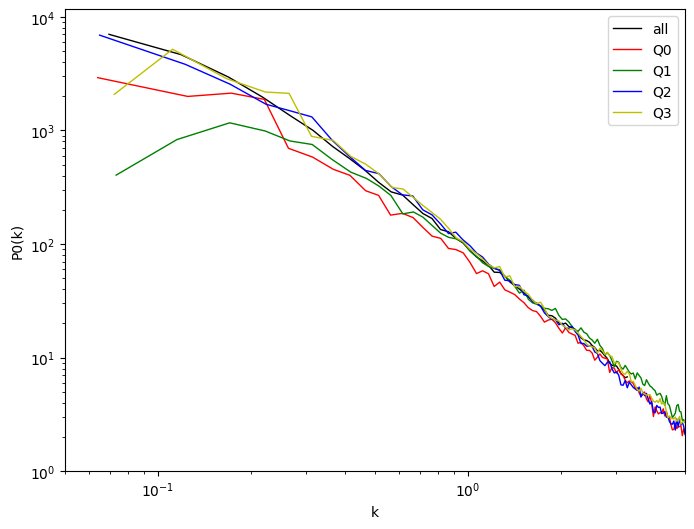

In [214]:
labels = ['all', 'Q0', 'Q1', 'Q2', 'Q3']
cs = ['k', 'r', 'g', 'b', 'y']

f, ax = plt.subplots(1,1, figsize=(8, 6))
for i, Pk in enumerate([Pk0]+Pks):
    ax.plot(Pk[0], Pk[1], label=labels[i], lw=1, color=cs[i])

ax.legend()
ax.loglog()
ax.set(xlabel='k', ylabel='P0(k)');
ax.set_ylim(1)
ax.set_xlim(0.05, 5)

## Prepare for Lucia and Tjitske

In [13]:
# Load VAGC
with fits.open(pjoin(wdir, 'lss_index.dr72.fits')) as f:
    print(f.info())
    data = f[1].data

filename = pjoin(wdir, 'object_sdss_imaging.fits')
with fits.open(filename) as f:
    print(f.info())
    img = f[1].data

Filename: ../MGS/lss_index.dr72.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      10   ()      
  1                1 BinTableHDU     43   2506754R x 13C   [D, D, E, J, J, E, J, J, E, E, J, J, J]   
None
Filename: ../MGS/object_sdss_imaging.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    101   2506754R x 42C   [J, J, J, 3A, J, J, J, D, D, J, J, 5J, 5J, J, J, 5J, J, J, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, J, 5E, J, E, 5J, J, J, 5E, 5E, 5E, 5E, 5E]   
None


In [15]:
rae = 100, 270
dece = 0, 70
ze = 0.01, 0.035
def in_range(data):
    mask = (rae[0] < data['RA']) & (data['RA'] < rae[1]) & (dece[0] < data['DEC']) & (data['DEC'] < dece[1])
    mask &= (ze[0] <= data['Z']) & (data['Z'] < ze[1])
    return mask

mask = (data['VAGC_SELECT'] == 7) & (data['ILSS'] != -1)
mask &= in_range(data)
data = data[mask]
img = img[mask]

print(len(data), len(img))

41735 41735


In [16]:
from numpy.lib.recfunctions import rec_append_fields

to_add = list(data.dtype.names)
to_add.remove('RA')
to_add.remove('DEC')
to_add.remove('VAGC_SELECT')

img = rec_append_fields(img, to_add, 
                        data=[data[col] for col in to_add], 
                        dtypes=[data[col].dtype for col in to_add])

In [19]:
np.save(pjoin(wdir, 'vagc_photlss_04042024.npy'), img)

(array([104., 114., 100., 114., 133., 137.,  92., 109.,  88.,  91., 118.,
        111., 119., 113., 126., 143., 169., 171., 172., 162., 164., 180.,
        220., 189., 182., 179., 171., 165., 193., 188., 171., 164., 201.,
        172., 183., 197., 197., 189., 234., 246., 272., 266., 331., 395.,
        427., 472., 471., 471., 485., 541., 578., 600., 612., 618., 572.,
        550., 579., 513., 494., 531., 529., 528., 563., 471., 501., 508.,
        485., 509., 560., 563., 549., 580., 613., 646., 593., 700., 672.,
        618., 616., 607., 640., 682., 659., 734., 763., 702., 715., 676.,
        714., 723., 703., 703., 758., 763., 695., 707., 727., 751., 744.,
        716.]),
 array([0.01000012, 0.01025011, 0.0105001 , 0.01075009, 0.01100009,
        0.01125008, 0.01150007, 0.01175006, 0.01200006, 0.01225005,
        0.01250004, 0.01275003, 0.01300002, 0.01325002, 0.01350001,
        0.01375   , 0.01399999, 0.01424999, 0.01449998, 0.01474997,
        0.01499996, 0.01524996, 0.01549995, 0.

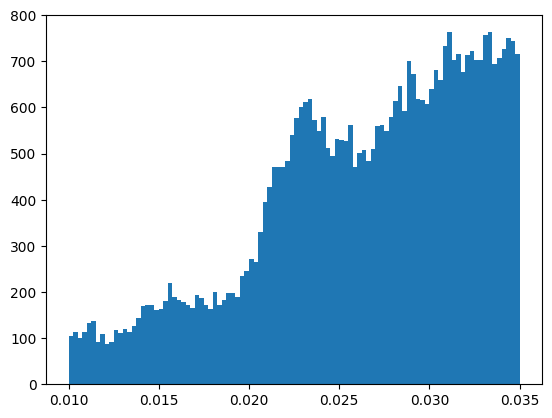

In [20]:
plt.hist(img['Z'], bins=100)

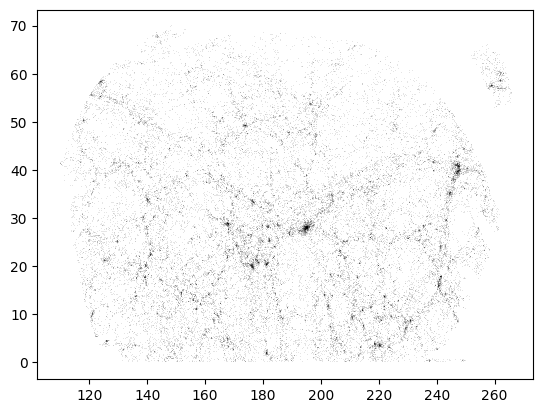

In [21]:
plt.plot(img['RA'], img['DEC'], 'k,', alpha=0.1)